<a href="https://colab.research.google.com/github/sahil3Vedi/Custom-NER-Spacy/blob/main/Rental_Entity_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###1 Importing Dependencies

In [1]:
!pip install python-docx

     |████████████████████████████████| 5.6MB 7.2MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-cp37-none-any.whl size=184508 sha256=757d3c498584213552ebd1a9a59b5e2cb4b2a3d312d7bb6648351c5bfa44279a
  Stored in directory: /root/.cache/pip/wheels/a6/90/f1/a7cb70b38633ae04e7fb963b1c70f63fd6fc01c075b8230adc
Successfully built python-docx


In [2]:
# Importing Dependencies
import os
import numpy as np
import pandas as pd
from docx import Document
import spacy
import nltk
import matplotlib.pyplot as plt
import math
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
import re
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


###2 Importing Files

In [3]:
# Importing Training Word Files from Google Drive
TRAINING_DOCS_LOC = 'drive/My Drive/Zycus/Training_data'
TRAINING_DOCS_NAMES = os.listdir(TRAINING_DOCS_LOC)
TRAINING_DOCS_PATHS = [os.path.join(TRAINING_DOCS_LOC,DOC_NAME) for DOC_NAME in TRAINING_DOCS_NAMES]

###3 Preparing Data

In [4]:
def getRealFileName(file_name):
  return file_name.split(".")[0]

TRAINING_DATA = pd.read_csv('drive/My Drive/Zycus/TrainingTestSet.csv')
FILE_NAME_DATA = [getRealFileName(N) for N in TRAINING_DOCS_NAMES]
Y_TRAIN = pd.DataFrame(columns = TRAINING_DATA.columns)
# remove bad data from training data
for n in range(len(TRAINING_DATA)):
  TRAINING_ROW = TRAINING_DATA.loc[n]
  AGREEMENT_NAME = TRAINING_ROW["File Name"]
  if (AGREEMENT_NAME in FILE_NAME_DATA):
    Y_TRAIN = Y_TRAIN.append(TRAINING_ROW)

Y_TRAIN

,File Name,Aggrement Value,Aggrement Start Date,Aggrement End Date,Renewal Notice (Days),Party One,Party Two
8,6683127-House-Rental-Contract-GERALDINE-GALINA...,6500.0,20.05.2007,20.05.2008,15.0,"Antonio Levy S. Ingles, Jr. and/or Mary Rose C...",GERALDINE Q. GALINATO
9,6683129-House-Rental-Contract-Geraldine-Galina...,6500.0,20.05.2007,20.05.2008,15.0,"Antonio Levy S. Ingles, Jr. and/or Mary Rose C...",GERALDINE Q. GALINATO
10,18325926-Rental-Agreement-1,4000.0,05.12.2008,31.11.2009,90.0,MR.K.Kuttan,P.M. Narayana Namboodri
12,36199312-Rental-Agreement,3800.0,01.05.2010,31.04.2011,30.0,Balaji.R,Kartheek R
13,44737744-Maddireddy-Bhargava-Reddy-Rental-Agre...,3000.0,20.09.2010,19.07.2011,NaN,M.V.V. VIJAYA SHANKAR,MADDIREDDY BHARGAVA REDDY
14,46239065-Standard-Rental-Agreement-Rental-With...,700.0,15.12.2008,NaN,NaN,"PROSPER 4 LESS,LLC",Jose Luis Salcido
15,47854715-RENTAL-AGREEMENT,9000.0,01.04.2010,31.02.2011,60.0,P C MATHEW,L GOPINATH
16,50070534-RENTAL-AGREEMENT (1),10000.0,01.04.2010,30.03.2011,90.0,P. JohnsonRavikumar,Saravanan BV
17,54770958-Rental-Agreement,8000.0,01.04.2011,31.03.2012,90.0,K. Parthasarathy,Veerabrahmam Bathini
18,54945838-Rental-Agreement,5500.0,21.04.2011,19.02.2012,60.0,Asha Ramesh & Ramesh K.N,Sadasivuni Deepthi & Sadasivuni Kiran


###4 Using Spacy to Label Training Data

In [5]:
# using SpaCy custom NER

#we need mulitple instances of the spacy.load() module
#because we want multiple classifiers
nlp = spacy.load('en_core_web_sm')
nlp_agreement_value = spacy.load('en_core_web_sm')
nlp_renewal_notice = spacy.load('en_core_web_sm')
nlp_party_one = spacy.load('en_core_web_sm')
nlp_party_two = spacy.load('en_core_web_sm')

def fetchTrainingPartyOne(FILE_NAME, Party_One):
  DOC_PATH = os.path.join(TRAINING_DOCS_LOC, FILE_NAME)
  document = Document(DOC_PATH+".pdf.docx")
  complete_text = ""
  # custom entity labels
  party_one = Party_One
  # each paragraph has some text that is added to the complete_text
  for para in document.paragraphs:
    text = para.text
    text = re.sub(r'\s+',' ',text)
    if (text!=" " and text!=""):
      complete_text += (text + " ")
  # checking the presence of the required entity labels.
  doc_entities = []
  # party_one
  if (party_one and isinstance(party_one, str)):
    party_one_index = complete_text.find(party_one[0:len(party_one)])
    if (party_one_index != -1):
      doc_entities.append((party_one_index,party_one_index+len(party_one),"Party_One"))
  return ((complete_text,{"entities":doc_entities}))

def fetchTrainingPartyTwo(FILE_NAME, Party_Two):
  DOC_PATH = os.path.join(TRAINING_DOCS_LOC, FILE_NAME)
  document = Document(DOC_PATH+".pdf.docx")
  complete_text = ""
  # custom entity labels
  party_two = Party_Two
  # each paragraph has some text that is added to the complete_text
  for para in document.paragraphs:
    text = para.text
    text = re.sub(r'\s+',' ',text)
    if (text!=" " and text!=""):
      complete_text += (text + " ")
  # checking the presence of the required entity labels.
  doc_entities = []
  # party_two
  if (party_two and isinstance(party_two, str)):
    party_two_index = complete_text.find(party_two[0:len(party_two)])
    if (party_two_index != -1):
      doc_entities.append((party_two_index,party_two_index+len(party_two),"Party_Two"))
  return ((complete_text,{"entities":doc_entities}))

def fetchTrainingRenewalNotice(FILE_NAME, Renewal_Notice):
  DOC_PATH = os.path.join(TRAINING_DOCS_LOC, FILE_NAME)
  document = Document(DOC_PATH+".pdf.docx")
  complete_text = ""
  # custom entity labels
  renewal_notice = Renewal_Notice
  # each paragraph has some text that is added to the complete_text
  for para in document.paragraphs:
    text = para.text
    text = re.sub(r'\s+',' ',text)
    if (text!=" " and text!=""):
      complete_text += (text + " ")
  # checking the presence of the required entity labels.
  doc_entities = []
  # renewal notice period
  if (renewal_notice and not (math.isnan(renewal_notice))):
    refined_notice = str(int(renewal_notice))
    renewal_notice_index = complete_text.find(refined_notice[0:len(refined_notice)])
    if (renewal_notice_index != -1):
      doc_entities.append((renewal_notice_index,renewal_notice_index+len(refined_notice),"Renewal_Notice"))
  return ((complete_text,{"entities":doc_entities}))

def fetchTrainingAgreementValues(FILE_NAME, Agreement_Value):
  DOC_PATH = os.path.join(TRAINING_DOCS_LOC, FILE_NAME)
  document = Document(DOC_PATH+".pdf.docx")
  complete_text = ""
  # custom entity labels
  agreement_value = Agreement_Value
  # each paragraph has some text that is added to the complete_text
  for para in document.paragraphs:
    text = para.text
    text = re.sub(r'\s+',' ',text)
    if (text!=" " and text!=""):
      complete_text += (text + " ")
  # checking the presence of the required entity labels.
  doc_entities = []
  # agreement value
  if (agreement_value and not (math.isnan(agreement_value))):
    refined_value = str(int(agreement_value))
    agreement_value_index = complete_text.find(refined_value[0:len(refined_value)])
    if (agreement_value_index != -1):
      doc_entities.append((agreement_value_index, agreement_value_index + len(refined_value),"Agreement_Value"))
  return ((complete_text,{"entities":doc_entities}))

def fetchTrainingInputs(FILE_NAME, Agreement_Value, Agreement_Start, Agreement_End, Renewal_Notice, Party_One, Party_Two):
  DOC_PATH = os.path.join(TRAINING_DOCS_LOC, FILE_NAME)
  document = Document(DOC_PATH+".pdf.docx")
  complete_text = ""
  # custom entity labels
  agreement_value = Agreement_Value
  agreement_start = Agreement_Start
  agreement_end = Agreement_End
  renewal_notice = Renewal_Notice
  party_one = Party_One
  party_two = Party_Two
  # each paragraph has some text that is added to the complete_text
  for para in document.paragraphs:
    text = para.text
    text = re.sub(r'\s+',' ',text)
    if (text!=" " and text!=""):
      complete_text += (text + " ")
  # checking the presence of the required entity labels.
  doc_entities = []
  # party_one and party_two can be determined by simple substring index matching
  if (party_one and isinstance(party_one, str)):
    party_one_index = complete_text.find(party_one[0:len(party_one)])
    if (party_one_index != -1):
      doc_entities.append((party_one_index,party_one_index+len(party_one),"Party_One"))
  if (party_two and isinstance(party_two, str)):
    party_two_index = complete_text.find(party_two[0:len(party_two)])
    if (party_two_index != -1):
      doc_entities.append((party_two_index,party_two_index+len(party_two),"Party_Two"))
  # renewal notice period
  if (renewal_notice and not (math.isnan(renewal_notice))):
    refined_notice = str(int(renewal_notice))
    renewal_notice_index = complete_text.find(refined_notice[0:len(refined_notice)])
    if (renewal_notice_index != -1):
      doc_entities.append((renewal_notice_index,renewal_notice_index+len(refined_notice),"Renewal_Notice"))
  # agreement value
  if (agreement_value and not (math.isnan(agreement_value))):
    refined_value = str(int(agreement_value))
    agreement_value_index = complete_text.find(refined_value[0:len(refined_value)])
    if (agreement_value_index != -1):
      doc_entities.append((agreement_value_index, agreement_value_index + len(refined_value),"Agreement_Value"))
  return ((complete_text,{"entities":doc_entities}))

train = [fetchTrainingInputs(Y_TRAIN.iloc[n,0],Y_TRAIN.iloc[n,1],Y_TRAIN.iloc[n,2],Y_TRAIN.iloc[n,3],Y_TRAIN.iloc[n,4],Y_TRAIN.iloc[n,5],Y_TRAIN.iloc[n,6]) for n in range(0,len(Y_TRAIN))]
train_agreement_value = [fetchTrainingAgreementValues(Y_TRAIN.iloc[n,0],Y_TRAIN.iloc[n,1]) for n in range(0,len(Y_TRAIN))]
train_renewal_notice = [fetchTrainingRenewalNotice(Y_TRAIN.iloc[n,0],Y_TRAIN.iloc[n,4]) for n in range(0,len(Y_TRAIN))]
train_party_one = [fetchTrainingPartyOne(Y_TRAIN.iloc[n,0],Y_TRAIN.iloc[n,5]) for n in range(0,len(Y_TRAIN))]
train_party_two = [fetchTrainingPartyTwo(Y_TRAIN.iloc[n,0],Y_TRAIN.iloc[n,6]) for n in range(0,len(Y_TRAIN))]

###5 Training

In [6]:
import random
from spacy.util import minibatch, compounding
from pathlib import Path

# Overall Classifier Pipes
ner = nlp.get_pipe("ner")
for _,annotations in train:
  for ent in annotations.get("entities"):
    ner.add_label(ent[2])

# Agreement Value Classifier Pipes
ner_agreement_value = nlp_agreement_value.get_pipe("ner")
for _,annotations in train_agreement_value:
  for ent in annotations.get("entities"):
    ner_agreement_value.add_label(ent[2])

# Renewal Notice Classifier Pipes
ner_renewal_notice = nlp_renewal_notice.get_pipe("ner")
for _,annotations in train_renewal_notice:
  for ent in annotations.get("entities"):
    ner_renewal_notice.add_label(ent[2])

# Party One Classifier Pipes
ner_party_one = nlp_party_one.get_pipe("ner")
for _,annotations in train_party_one:
  for ent in annotations.get("entities"):
    ner_party_one.add_label(ent[2])

# Party Two Classifier Pipes
ner_party_two = nlp_party_two.get_pipe("ner")
for _,annotations in train_party_two:
  for ent in annotations.get("entities"):
    ner_party_two.add_label(ent[2])


disable_pipes = [pipe for pipe in nlp.pipe_names if ((pipe != 'ner') and (pipe != 'ner_agreement_value') and (pipe != 'ner_renewal_notice') and (pipe != 'ner_party_one') and (pipe != 'ner_party_two'))]

####5.1 Training Overall classifier

-----
GENERAL CLASSIFIER
-----
Epoch 1 of 32 Loss = 2522.3225068870233 Batch 11/11
Epoch 2 of 32 Loss = 998.0344932433945 Batch 11/11
Epoch 3 of 32 Loss = 1307.420968616556 Batch 11/11
Epoch 4 of 32 Loss = 1024.489609168595 Batch 11/11
Epoch 5 of 32 Loss = 860.4093529689417 Batch 11/11
Epoch 6 of 32 Loss = 835.3869525566406 Batch 11/11
Epoch 7 of 32 Loss = 1030.1990417243214 Batch 11/11
Epoch 8 of 32 Loss = 758.5148544860422 Batch 11/11
Epoch 9 of 32 Loss = 816.2835825337097 Batch 11/11
Epoch 10 of 32 Loss = 1159.0609049516788 Batch 11/11
Epoch 11 of 32 Loss = 989.7712380972862 Batch 11/11
Epoch 12 of 32 Loss = 1011.9553290850017 Batch 11/11
Epoch 13 of 32 Loss = 1670.2093568593264 Batch 11/11
Epoch 14 of 32 Loss = 1372.588837592736 Batch 11/11
Epoch 15 of 32 Loss = 804.7506596355815 Batch 11/11
Epoch 16 of 32 Loss = 1246.4415463302284 Batch 11/11
Epoch 17 of 32 Loss = 1077.3731950903311 Batch 11/11
Epoch 18 of 32 Loss = 800.2248965459876 Batch 11/11
Epoch 19 of 32 Loss = 834.118082779

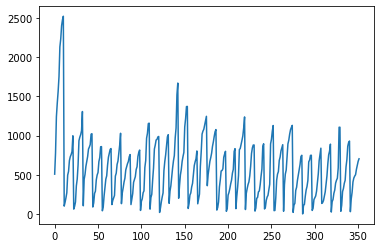

In [7]:
loss_val = []
epochs = 32

print("-----")
print("GENERAL CLASSIFIER")
print("-----")

with nlp.disable_pipes(*disable_pipes):
  optimizer = nlp.resume_training()
  for iteration in range(epochs):
    random.shuffle(train)
    losses = {}
    batches = minibatch(train, size=compounding(4.0,32.0,1.001))
    count = 0
    for batch in batches:
      count+=1
      text,annotation = zip(*batch)
      nlp.update(
          text,
          annotation,
          sgd = optimizer,
          losses = losses
      )
      if len(list(losses.values())):
        loss_val.append(list(losses.values())[0])
    print("Epoch " + str(iteration+1) + " of " + str(epochs) + " Loss = " + str(losses['ner']) + " Batch " + str(count) + "/" + str(count))

plt.plot(loss_val)

print()
print("---GENERAL CLASSIFIER TRAINING PERFORMANCE---")

for text, _ in train:
  doc = nlp(text)
  print('Entities',[(ent.text, ent.label_) for ent in doc.ents])

####5.2 Training Agreement Value Classifier

-----
AGREEMENT VALUE CLASSIFIER
-----
Epoch 1 of 32 Loss = 2135.446102761758 Batch 11/11
Epoch 2 of 32 Loss = 655.9790505896093 Batch 11/11
Epoch 3 of 32 Loss = 745.3459570638262 Batch 11/11
Epoch 4 of 32 Loss = 544.43979033189 Batch 11/11
Epoch 5 of 32 Loss = 624.9329581417066 Batch 11/11
Epoch 6 of 32 Loss = 511.51757331216993 Batch 11/11
Epoch 7 of 32 Loss = 585.8672362723303 Batch 11/11
Epoch 8 of 32 Loss = 605.8354900268921 Batch 11/11
Epoch 9 of 32 Loss = 577.64499168056 Batch 11/11
Epoch 10 of 32 Loss = 551.5051699058483 Batch 11/11
Epoch 11 of 32 Loss = 557.2516976751783 Batch 11/11
Epoch 12 of 32 Loss = 520.5122394965892 Batch 11/11
Epoch 13 of 32 Loss = 537.8999669061383 Batch 11/11
Epoch 14 of 32 Loss = 783.8888382642489 Batch 11/11
Epoch 15 of 32 Loss = 538.4887109432199 Batch 11/11
Epoch 16 of 32 Loss = 537.0135137965074 Batch 11/11
Epoch 17 of 32 Loss = 596.829566686482 Batch 11/11
Epoch 18 of 32 Loss = 959.1237659957584 Batch 11/11
Epoch 19 of 32 Loss = 473.117276164586

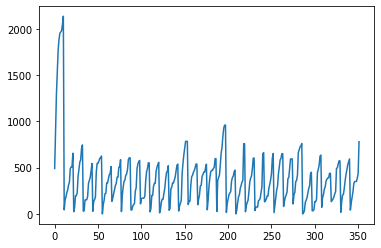

In [8]:
loss_val = []
epochs = 32

print("-----")
print("AGREEMENT VALUE CLASSIFIER")
print("-----")

with nlp_agreement_value.disable_pipes(*disable_pipes):
  optimizer = nlp_agreement_value.resume_training()
  for iteration in range(epochs):
    random.shuffle(train_agreement_value)
    losses = {}
    batches = minibatch(train_agreement_value, size=compounding(4.0,32.0,1.001))
    count = 0
    for batch in batches:
      count+=1
      text,annotation = zip(*batch)
      nlp_agreement_value.update(
          text,
          annotation,
          sgd = optimizer,
          losses = losses
      )
      if len(list(losses.values())):
        loss_val.append(list(losses.values())[0])
    print("Epoch " + str(iteration+1) + " of " + str(epochs) + " Loss = " + str(losses['ner']) + " Batch " + str(count) + "/" + str(count))

plt.plot(loss_val)

print()
print("---AGREEMENT VALUE CLASSIFIER TRAINING PERFORMANCE---")

for text, _ in train_agreement_value:
  doc = nlp_agreement_value(text)
  print('Entities',[(ent.text, ent.label_) for ent in doc.ents])

####5.3 Training Renewal Notice Classifier



-----
RENEWAL NOTICE CLASSIFIER
-----
Epoch 1 of 32 Loss = 1542.101023390115 Batch 11/11
Epoch 2 of 32 Loss = 178.3798274830986 Batch 11/11
Epoch 3 of 32 Loss = 317.5212473494011 Batch 11/11
Epoch 4 of 32 Loss = 227.83273247354907 Batch 11/11
Epoch 5 of 32 Loss = 230.32966247162975 Batch 11/11
Epoch 6 of 32 Loss = 210.38168036432788 Batch 11/11
Epoch 7 of 32 Loss = 327.45760062904503 Batch 11/11
Epoch 8 of 32 Loss = 255.8108343654839 Batch 11/11
Epoch 9 of 32 Loss = 239.59164985643596 Batch 11/11
Epoch 10 of 32 Loss = 257.24096747951364 Batch 11/11
Epoch 11 of 32 Loss = 270.90557192279897 Batch 11/11
Epoch 12 of 32 Loss = 248.19322944308652 Batch 11/11
Epoch 13 of 32 Loss = 245.4532381267089 Batch 11/11
Epoch 14 of 32 Loss = 204.48961317095726 Batch 11/11
Epoch 15 of 32 Loss = 197.32476938485016 Batch 11/11
Epoch 16 of 32 Loss = 235.97182388717454 Batch 11/11
Epoch 17 of 32 Loss = 229.9302425709623 Batch 11/11
Epoch 18 of 32 Loss = 223.88345949250123 Batch 11/11
Epoch 19 of 32 Loss = 1

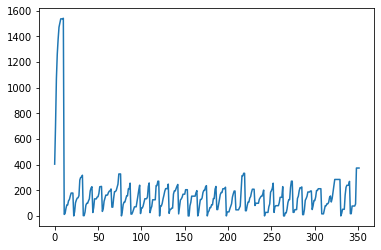

In [9]:
loss_val = []
epochs = 32

print("-----")
print("RENEWAL NOTICE CLASSIFIER")
print("-----")

with nlp_renewal_notice.disable_pipes(*disable_pipes):
  optimizer = nlp_renewal_notice.resume_training()
  for iteration in range(epochs):
    random.shuffle(train_renewal_notice)
    losses = {}
    batches = minibatch(train_renewal_notice, size=compounding(4.0,32.0,1.001))
    count = 0
    for batch in batches:
      count+=1
      text,annotation = zip(*batch)
      nlp_renewal_notice.update(
          text,
          annotation,
          sgd = optimizer,
          losses = losses
      )
      if len(list(losses.values())):
        loss_val.append(list(losses.values())[0])
    print("Epoch " + str(iteration+1) + " of " + str(epochs) + " Loss = " + str(losses['ner']) + " Batch " + str(count) + "/" + str(count))

plt.plot(loss_val)

print()
print("---RENEWAL NOTICE CLASSIFIER TRAINING PERFORMANCE---")

for text, _ in train_renewal_notice:
  doc = nlp_renewal_notice(text)
  print('Entities',[(ent.text, ent.label_) for ent in doc.ents])

####5.4 Training Party One Classifier

-----
PARTY ONE CLASSIFIER
-----
Epoch 1 of 32 Loss = 2465.613736148458 Batch 11/11
Epoch 2 of 32 Loss = 544.6526479166205 Batch 11/11
Epoch 3 of 32 Loss = 814.6386410109085 Batch 11/11
Epoch 4 of 32 Loss = 580.4491506412087 Batch 11/11
Epoch 5 of 32 Loss = 700.1113326967092 Batch 11/11
Epoch 6 of 32 Loss = 577.6056362054387 Batch 11/11
Epoch 7 of 32 Loss = 660.5402854049117 Batch 11/11
Epoch 8 of 32 Loss = 572.3570537281507 Batch 11/11
Epoch 9 of 32 Loss = 698.2796944982219 Batch 11/11
Epoch 10 of 32 Loss = 904.9417906173621 Batch 11/11
Epoch 11 of 32 Loss = 621.0554304024172 Batch 11/11
Epoch 12 of 32 Loss = 788.7693599842455 Batch 11/11
Epoch 13 of 32 Loss = 1089.507102993632 Batch 11/11
Epoch 14 of 32 Loss = 608.2919899242484 Batch 11/11
Epoch 15 of 32 Loss = 509.5656490223342 Batch 11/11
Epoch 16 of 32 Loss = 635.8239853783832 Batch 11/11
Epoch 17 of 32 Loss = 433.8137982265088 Batch 11/11
Epoch 18 of 32 Loss = 627.1923871292449 Batch 11/11
Epoch 19 of 32 Loss = 753.354837823396 B

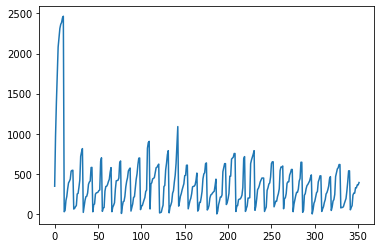

In [10]:
loss_val = []
epochs = 32

print("-----")
print("PARTY ONE CLASSIFIER")
print("-----")

with nlp_party_one.disable_pipes(*disable_pipes):
  optimizer = nlp_party_one.resume_training()
  for iteration in range(epochs):
    random.shuffle(train_party_one)
    losses = {}
    batches = minibatch(train_party_one, size=compounding(4.0,32.0,1.001))
    count = 0
    for batch in batches:
      count+=1
      text,annotation = zip(*batch)
      nlp_party_one.update(
          text,
          annotation,
          sgd = optimizer,
          losses = losses
      )
      if len(list(losses.values())):
        loss_val.append(list(losses.values())[0])
    print("Epoch " + str(iteration+1) + " of " + str(epochs) + " Loss = " + str(losses['ner']) + " Batch " + str(count) + "/" + str(count))

plt.plot(loss_val)

print()
print("---PARTY ONE CLASSIFER TRAINING PERFORMANCE---")

for text, _ in train_party_one:
  doc = nlp_party_one(text)
  print('Entities',[(ent.text, ent.label_) for ent in doc.ents])

####5.5 Training Party Two Classifier

-----
PARTY TWO CLASSIFIER
-----
Epoch 1 of 32 Loss = 2397.028490447963 Batch 11/11
Epoch 2 of 32 Loss = 517.9417701927084 Batch 11/11
Epoch 3 of 32 Loss = 702.7812145765026 Batch 11/11
Epoch 4 of 32 Loss = 690.9370874792512 Batch 11/11
Epoch 5 of 32 Loss = 766.9797462884562 Batch 11/11
Epoch 6 of 32 Loss = 1085.71487491282 Batch 11/11
Epoch 7 of 32 Loss = 888.5412118712266 Batch 11/11
Epoch 8 of 32 Loss = 818.6210499370864 Batch 11/11
Epoch 9 of 32 Loss = 953.6045169179197 Batch 11/11
Epoch 10 of 32 Loss = 723.373042749241 Batch 11/11
Epoch 11 of 32 Loss = 1188.4753857149044 Batch 11/11
Epoch 12 of 32 Loss = 964.9339738355945 Batch 11/11
Epoch 13 of 32 Loss = 656.1565599231042 Batch 11/11
Epoch 14 of 32 Loss = 738.6074484842107 Batch 11/11
Epoch 15 of 32 Loss = 716.7636211779674 Batch 11/11
Epoch 16 of 32 Loss = 429.23898058589015 Batch 11/11
Epoch 17 of 32 Loss = 758.3550794799371 Batch 11/11
Epoch 18 of 32 Loss = 523.7457394190304 Batch 11/11
Epoch 19 of 32 Loss = 570.1157520218775 

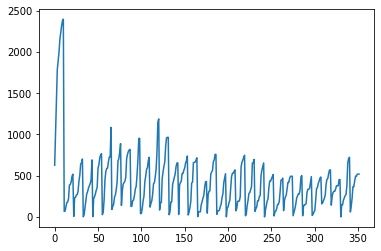

In [11]:
loss_val = []
epochs = 32

print("-----")
print("PARTY TWO CLASSIFIER")
print("-----")

with nlp_party_two.disable_pipes(*disable_pipes):
  optimizer = nlp_party_two.resume_training()
  for iteration in range(epochs):
    random.shuffle(train_party_two)
    losses = {}
    batches = minibatch(train_party_two, size=compounding(4.0,32.0,1.001))
    count = 0
    for batch in batches:
      count+=1
      text,annotation = zip(*batch)
      nlp_party_two.update(
          text,
          annotation,
          sgd = optimizer,
          losses = losses
      )
      if len(list(losses.values())):
        loss_val.append(list(losses.values())[0])
    print("Epoch " + str(iteration+1) + " of " + str(epochs) + " Loss = " + str(losses['ner']) + " Batch " + str(count) + "/" + str(count))

plt.plot(loss_val)

print()
print("---PARTY TWO CLASSIFER TRAINING PERFORMANCE---")

for text, _ in train_party_two:
  doc = nlp_party_two(text)
  print('Entities',[(ent.text, ent.label_) for ent in doc.ents])

###6 Validation

In [12]:
# Importing Validation Word Files from Google Drive
VALIDATION_DOCS_LOC = 'drive/My Drive/Zycus/Validation_Data'
VALIDATION_DOCS_NAMES = os.listdir(VALIDATION_DOCS_LOC)
VALIDATION_DOCS_PATHS = [os.path.join(VALIDATION_DOCS_LOC,DOC_NAME) for DOC_NAME in VALIDATION_DOCS_NAMES]

VALIDATION_DATA = pd.read_csv('drive/My Drive/Zycus/ValidationSet.csv')
FILE_NAME_DATA = [getRealFileName(N) for N in VALIDATION_DOCS_NAMES]
Y_VAL = pd.DataFrame(columns = VALIDATION_DATA.columns)
# remove bad data from training data
for n in range(len(VALIDATION_DATA)):
  VAL_ROW = VALIDATION_DATA.loc[n]
  AGREEMENT_NAME = VAL_ROW["File Name"]
  if (AGREEMENT_NAME in FILE_NAME_DATA):
    Y_VAL = Y_VAL.append(VAL_ROW)

Y_VAL

,File Name,Aggrement Value,Aggrement Start Date,Aggrement End Date,Renewal Notice (Days),Party One,Party Two
0,24158401-Rental-Agreement,12000,01.04.2008,31.03.2009,60.0,Hanumaiah,Vishal Bhardwaj
1,63793679-Rental-Agreement,9000,01.09.2011,31.08.2012,NaN,S Parthasarathy,Hari Kiran Tholeti
2,95980236-Rental-Agreement,9000,01.04.2010,31.03.2011,30.0,S.Sakunthala,V.V.Ravi Kian
3,156155545-Rental-Agreement-Kns-Home,12000,15.12.2012,14.11.2013,30.0,V.K.NATARAJ,VYSHNAVI DAIRY SPECIALITIES Private Ltd
4,195231682-This-RENTAL-AGREEMENT-is-Made-and-Ex...,13000,06.04.2013,05.03.2014,30.0,C.BHAGYAMMA,JP INTERIO
5,228094620-Rental-Agreement,15000,07.07.2013,06.06.2014,30.0,KAPIL MEHROTRA,.B.Kishore
6,239419594-Rental-Agreement,9000,07.07.2014,06.06.2015,90.0,Abraham,Annamalai
7,269135973-Udaya-Rental-Agreement,8300,01.04.2014,31.02.2013,30.0,Giddappa,Pottumurthi Udayalaxmi


In [13]:
def fetchValidationSet(FILE_NAME):
  # scan document for sentences and their respective entity labels (supervised)
  DOC_PATH = os.path.join(VALIDATION_DOCS_LOC, FILE_NAME)
  document = Document(DOC_PATH+".pdf.docx")
  sentences = []
  complete_text = ""
  # each paragraph has some text that is added to the complete_text
  for para in document.paragraphs:
    text = para.text
    text = re.sub(r'\s+',' ',text)
    if (text!=" " and text!=""):
      complete_text += (text + " ")
  # restricting to first 500 characters for performance
  complete_text = complete_text[0:500]
  # checking the presence of the required entity labels.
  doc_entities = []
  return ((complete_text,{"entities":doc_entities}))

validation = [fetchValidationSet(Y_VAL.iloc[n,0]) for n in range(0,len(Y_VAL))]

In [14]:
print()
print("---GENERAL CLASSIFIER VALIDATION PERFORMANCE---")
for text, _ in validation:
  doc = nlp(text)
  print('Entities',[(ent.text, ent.label_) for ent in doc.ents])

print()
print("---AGREEMENT VALUE CLASSIFIER VALIDATION PERFORMANCE---")
for text, _ in validation:
  doc = nlp_agreement_value(text)
  print('Entities',[(ent.text, ent.label_) for ent in doc.ents])

print()
print("---RENEWAL NOTICE CLASSIFIER VALIDATION PERFORMANCE---")
for text, _ in validation:
  doc = nlp_renewal_notice(text)
  print('Entities',[(ent.text, ent.label_) for ent in doc.ents])

print()
print("---PARTY ONE CLASSIFIER VALIDATION PERFORMANCE---")
for text, _ in validation:
  doc = nlp_party_one(text)
  print('Entities',[(ent.text, ent.label_) for ent in doc.ents])

print()
print("---PARTY TWO CLASSIFIER VALIDATION PERFORMANCE---")
for text, _ in validation:
  doc = nlp_party_two(text)
  print('Entities',[(ent.text, ent.label_) for ent in doc.ents])


---GENERAL CLASSIFIER VALIDATION PERFORMANCE---
Entities []
Entities [('S Parthasarathy', 'Party_One'), ('Hari Kiran Tholeti', 'Party_Two')]
Entities [('V.V.Ravi Kian', 'Party_Two')]
Entities []
Entities [('C.BHAGYAMMA', 'Party_One'), ('JP INTERIO', 'Party_Two')]
Entities [('KAPIL MEHROTRA', 'Party_Two')]
Entities []
Entities [('Pottumurthi Udayalaxmi', 'Party_Two')]

---AGREEMENT VALUE CLASSIFIER VALIDATION PERFORMANCE---
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []

---RENEWAL NOTICE CLASSIFIER VALIDATION PERFORMANCE---
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []

---PARTY ONE CLASSIFIER VALIDATION PERFORMANCE---
Entities []
Entities [('S Parthasarathy', 'Party_One')]
Entities []
Entities []
Entities [('C.BHAGYAMMA', 'Party_One')]
Entities []
Entities []
Entities []

---PARTY TWO CLASSIFIER VALIDATION PERFORMANCE---
Entities []
Entities [('Hari Kiran Tholeti', 'Party_Two')]
Entitie